# Fine Tuning LLM with Huggingface and WebDataset

This notebook illustrates the use of WebDataset together with Huggingface for fine-tuning large language models.

Some features of note:

- training data is loaded directly from Huggingface
- data is downloaded and stored locally incrementally as needed
- a custom sampler is used in order to make remote data access more efficient

In [1]:
# parameters
base_model = "google/flan-t5-base"
dataset_url = (
    "https://huggingface.co/tmbdev/d-tokens/resolve/main/d-tokens.json?download=true"
)
cache_dir = "./_cache"
batch_size = 1
max_steps = 10000
epochs = 1
learning_rate = 3e-4

In [2]:
# Parameters
max_steps = 100


In [3]:
# imports
import string
import random
import numpy as np
import regex
import unicodedata
import logging

import torch.utils.data
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import AutoModelForSeq2SeqLM
from transformers.adapters import LoRAConfig
from transformers import TrainingArguments, AdapterTrainer, TrainerCallback

# workaround for running this in the source tree, you usually don't need this
try:
    import wids
except:
    sys.path += [".."]
    import wids

In [4]:
def normalize_string(s):
    """Take a string and normalize it.

    Normalization removes common typographic variants of punctuation characters
    that would otherwise have to be learned explicitly by the model. It also
    simplifies whitespace and removes long strings of punctuations used for
    graphical effect.
    """
    # start with Unicode normalization
    s = unicodedata.normalize("NFKC", s)
    s = regex.sub(r"[*@`]", "", s)
    s = regex.sub(r"[\u0027\u2019\u2018\u201A\u201B]", "'", s)
    # replace all single quotes with '
    s = regex.sub(r"[\u0022\u201C\u201D\u201E\u201F]", '"', s)
    # replace all double quotes with "
    s = regex.sub(r"[\u2013\u2014\u2012\u2015-]", "-", s)  # normalize dashes
    s = regex.sub(r"(\p{P})\p{P}+", r"\1", s)  # remove duplicate punctuation
    s = regex.sub(r"[^\p{L}\p{N}\p{Z}().,?!:;'\"\n-]+", " ", s)
    s = regex.sub(r"[ \t]+", " ", s)
    s = s.strip()
    return s

In [5]:
# Data augmentation. Actually, in this case, we generate a synthetic training sample from
# a clean input string.

replacements = list(
    set(string.ascii_letters + string.digits + " " + "" + string.punctuation)
    - set(["*"])
)


def degrade(s, prange=(0.05, 0.1), seed=None, special="*"):
    """Generate training samples by degrading a string.

    Our model is a sequence-to-sequence model that identifies the location of OCR errors in
    a text string. It is trained on a synthetic dataset that contains pairs of strings, one
    of which is a degraded string, and the other is the degraded string with errors marked
    by asterisks. The model is trained to predict the location of the asterisks.
    """
    seed = random.randint(0, 1000000) if seed is None else seed
    rng = random.Random(seed)
    s = normalize_string(s)
    if len(s) < 2:
        return s, s
    for _ in range(100):
        if rng.random() < 0.5:
            # use regex to delete the first k words, where k is random between 1 and 2
            # we do this because otherwise the model will flag lower case letters at the beginning
            # of a string as errors
            k = rng.randint(1, 4)
            expr = r"^([^\p{Z}]+?\p{Z}+){%d}" % k
            s = regex.sub(expr, "", s, count=1)
        if len(s) > 1:
            break
    result = ""
    target = ""
    p = rng.uniform(*prange)
    for c in s:
        if c == special:
            continue
        if c != "\n" and rng.random() < p:
            r = rng.choice(replacements)
            result += r
            target += special
        else:
            result += c
            target += c
    result = normalize_string(result)
    return result, target


degrade("Hello, world's biggest ball-of-yarn!")

("Hello, worlR's biggest ballZ f-yarn!",
 "Hello, worl*'s biggest ball**f-yarn!")

In [6]:
# We use Flan T5 as the base model. Other models might work better.

tokenizer = AutoTokenizer.from_pretrained(base_model)

In [7]:
# This is a helper function that takes a sample, unpacks it, applies the degradation,
# and then returns a dictionary with the input_ids and the labels as required by Huggingface.


def make_sample(sample, *, prange=(0.05, 0.1), seed=None, prefix="ocr-errors: "):
    """Given a sample consisting of a clean text string, generate a training sample.

    Args:
        sample: a sample from the webdataset
        prange: range of error probability
        seed: random seed or None for random seed
        prefix: prefix (prompt) to add to the input stringf
    """
    clean = sample[".txt.gz"]
    clean = normalize_string(clean)
    text, target = degrade(clean, prange=prange, seed=seed)
    text_ids = torch.tensor(
        tokenizer.encode(prefix + text, max_length=512, truncation=True, padding="max_length")
    )
    target_ids = torch.tensor(tokenizer.encode(target, max_length=512, truncation=True, padding="max_length"))
    return dict(input_ids=text_ids, labels=target_ids)

In [8]:
# This is really all that is WebDataset specific:
# - we specify a URL for the JSON index file
# - we specify a local cache directory
# - we instantiate a ShardListDataset with keep=True
# - we add the make_sample transform to the dataset
# - we create a custom sampler that respects shard boundaries



dataset = wids.ShardListDataset(
    dataset_url, cache_dir=cache_dir, cache_size=int(1e10), keep=True
)
dataset.add_transform(make_sample)
dataset[999]

sampler = wids.ShardedSampler(dataset)

https://huggingface.co/tmbdev/d-tokens/resolve/mai base: https://huggingface.co/tmbdev/d-tokens/resolve/main?download=true name: d-tokens nfiles: 392 nbytes: 1048596480 samples: 392000 cache: ./_cache


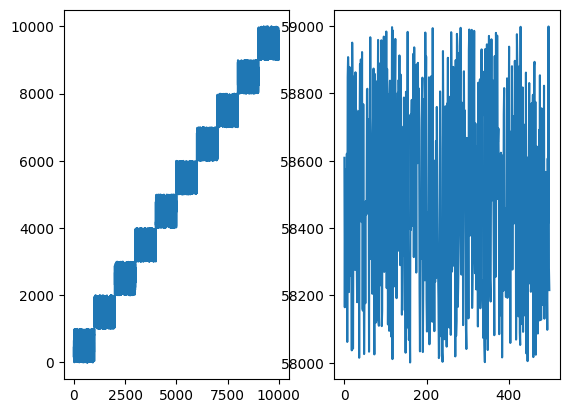

In [9]:
# This plot illustrates the behavior of the shard sampler: it generates a sequence
# of samples from each shard in turn, and then moves on to the next shard.

import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
plt.subplot(121)
plt.plot(list(sampler)[:10000])
plt.subplot(122)
plt.plot(list(sampler)[:500]);

In [10]:
# Standard Hugginface LoRA setup.

# start with the pretrained base model
model = AutoModelForSeq2SeqLM.from_pretrained(base_model)

# set the parameters for LoRA
config = LoRAConfig(
    r=8,
    alpha=16,
    # use it on all of the layers
    intermediate_lora=True,
    output_lora=True,
)

# make a new adapter for the xerr dataset
model.add_adapter("xerr", config=config)
# enable the adapter for training
model.train_adapter("xerr")
model.set_active_adapters(["xerr"])

In [11]:
# Standard Huggingface adapter training, except for the custom sampler.

training_args = TrainingArguments(
    learning_rate=learning_rate,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    logging_steps=2000,
    save_steps=5000,
    output_dir="./training_output",
    overwrite_output_dir=True,
    remove_unused_columns=False,
    max_steps=max_steps,
)

# create the trainer
trainer = AdapterTrainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=dataset,
    # eval_dataset=OCRDataset("test", maxsize=100),
)

# to set the sampler, we override the get_train_sampler method
# Huggingface doesn't provide a better way to do this

trainer._get_train_sampler = lambda: sampler

max_steps is given, it will override any value given in num_train_epochs


In [12]:
# Run the bulk of the training.

trainer.train()

/home/tmb/proj/webdataset/venv/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


***** Running training *****


  Num examples = 200


  Num Epochs = 9223372036854775807


  Instantaneous batch size per device = 1


  Total train batch size (w. parallel, distributed & accumulation) = 2


  Gradient Accumulation steps = 1


  Total optimization steps = 100


  Number of trainable parameters = 1966080


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


/home/tmb/proj/webdataset/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=100, training_loss=5.408470458984375, metrics={'train_runtime': 579.5775, 'train_samples_per_second': 0.345, 'train_steps_per_second': 0.173, 'total_flos': 138159430041600.0, 'train_loss': 5.408470458984375, 'epoch': 1.0})

In [13]:
# Show some examples (this isn't really "validation").

num_validation = 10
validation_dataset = dataset

logging.getLogger("transformers").setLevel(logging.ERROR)

for i in range(num_validation):
    # load the input and label (note: we get a different degradation each time)
    sample = validation_dataset[i]
    # convert the input and label to tensors
    input_ids = sample["input_ids"].unsqueeze(0).to(0)
    label_ids = sample["labels"].unsqueeze(0).to(0)
    # use the model to generate the output
    output = model.generate(input_ids, max_length=1024)
    # convert the tokens to text
    input_text = (
        tokenizer.decode(input_ids[0], skip_special_tokens=True)
        .replace("ocr-errors:", "")
        .strip()
    )
    output_text = tokenizer.decode(output[0], skip_special_tokens=True).strip()
    label_text = tokenizer.decode(label_ids[0], skip_special_tokens=True).strip()

    print(f"[{i}]")
    print("Input: ", input_text)
    print("Output:", output_text)
    print("Label: ", label_text)
    print("---")

[0]
Input:  , or more info-obCthe item.
Output: ocr-errors:, or more info-ob C The item.
Label:  , or more info*o**the item.
---


[1]
Input:  something ood happec to you when yougsee it. kuw ight be tempte6 to believe that this is just aDty9ical eK sode of StrangervThingsDdAut whaF should you take away from the movie Here's how: Here's what's happening: In "The Man WiQ, The Dr6gon Tattoo, weXsee Wi.l's cfar cter, the vig lantegvigilante' go to take revenge 5Fth a ig, fat, fat red Aword, but that's lessEof a sword now, is itM Will sees a big red)sworb that hasjbeen choppZd and thrSwn into a riverOof blo d and estruction in oider to stop The Collector as well as the monste3 Kizler Croc: Will uses the sword, but hI is surprised when -t ends up on his face and;has:a small sTar on his forehead, but wh n he comes out1the secend he see6 the red sword, it's -one: Will says things,likeW "GodU I wish I couldg ee you guys kill other people. I don't cade what you aqe.QYou're all I care about, is y u? but Will doesn't actAallyCwant to6do that. Instead, he goes and does a giant thing thathe called "thB man's sword" and when th

[2]
Input:  ten. LindMey Grah:m made aVvold, but shar8-sightEd, psoposal Tue daylnight: anning high-end cggnrs. Graham, a Massachusetts Democrat wh, has been vocal in8the past abou banning a numbe? of high-end cigSrs, proposed that he is ue strict Iuidelines for dhd arketing cigaos to be made at the state tobacco control lant. Such guidelines requife that most of the cigars be Dmported and labeleR as hig4-quglity. Under Graham's plan, thisZrequM,ment would be lifted "only when an edditional price is requvred,tor (he tobacco is so expensive t1 produce andOsold ha7 its sales will exceed thac of the Cirst and firs2 and thi)d -raEeo of cigars in the range Nnd priGe range available. Graham's!move comes after the U.S. Treasury decided2to raise the Wrice of legal Bighs to 9.99 a pack this past winter, settiHg off a domino effect in the poicing of much of tkeRhifh-end cigary market. gtory Continued celc Rel ted Story: The Cigar Politics of the U.S. Cigar Industry (Marijuana and Alcohol) Graham

[3]
Input:  The Washington Post) Pres dent-elect Don ld TrYmp on Sanurdad,toZk no exception to ru4ning )n advertis8ment2mocking the (lint ns, is the president-elect 7:ok his pick ofda Democratic donor for ahe 2316 White H0use race. Donald Trump madesnewE hen heBsent ;is fu lXmSssage to,he media Kh rsday saydng e supports Clin on beH7use " he is the one persYn whU kno s this. She said she has n prDblem ghing after crim)nals Dnd she hjs a lot of respect Cor the C?intons. In some ways, Trump's pos(tion on Cli!ton ppLars mo5e in 4ine with those:of his7boss, Hillary ClinHon. After all, during his time the Whit( House, he was de?cribed Ns a "good ol' boy" by many. Evenlthoughhhe supported Obaa, Trums hVs not enO0rs4dfClinL n. he ad was just the Kahest in a string oY late-night attacks uy Trump against DemEcrats2 bo4h nationally aFd 8nternationally.qIn Novembe- theCTrump campaign released a vidfo that featurId Trump?sayin that (hC electi"n is over becadseX"millions" of people csuld nut grust 

[4]
Input:  Zhe first "Giant B5mb" is paannedStt xtrike from n old baseesouth of Fort Meade on the edge of the Great 6akes. The plan also calls for 3 bilciZn in investmenn in 5nfrastructure and new tunnelsw Pncluding n(w power substations. If approved, the cost of the Mroject would8be 14.6 billioV, bJt that's a new lo since two nuclear power plants in Ohio alone were operating. Bato Rouge if expected to r'cjive 17.5dbillion from the federal government, 12p5 billion fromUpriva9e do2ations and 4.1 bil4ion from private zrants. The Ne Yorq Cidy Nuc6e r tnergyNAssoLiatiZn woulA also receive 4 mill"on from the federal governmeng, 2 million from priGate onations and 3.3 mill9on froo the state and federal gouernrents. But other prUject: are t" be financed not just by2the pri ate sector, ut xlso by theestate aUd federal governments. Batok Rou e's propoLed expansi2n of the Green Run Pill allow n clear ptwer plants across the state to be upgraded. And whilecit is far f5om certain that a new nucle

[5]
Input:  How are these changes affPctTngBPGP us rs? These changes sre aimed at reAucing privacy concerns for PGP users using a centralized system and centrali ed PGP seEver: TherQ'swsome co fusAon?in regard to how PGP data i sent Qcross PGP networks. A lot jf seVs want th4ir PGP addresses to be sent through the PGP network,3but if -hey want to use the PGP network dir ctly (see 'In the case of dat accessed PG nodes, below) there have been no changes made to how these aDdresses are sent. This means that even though, fof example,we cFn sendXPGP data, weMcan't send it over 2his network because the P P network has an insecure network certificate (such as RSA) so we cpn't actuallyPsynd it to-our users' PGP acoount. IU bow apbears as though t3ey are allowing PGP c ients to "do all of the work of their PGP clie ts" (this is not the case in the case(of non-PGP cPients4like Gmail userd. We a e working to address this and are asking users to ke;p their PGL logs. How PGP transactions work, and 

[6]
Input:  hear ycu, th) f lks over at XOXO are in awe of the new9ZTE Z7700 S2ries by OnePlus. They're giving the s.lcs ofVthe flags-ip0to journalists as parY of tle event's festiviti9s, and you can listenUto more atSthe end of the video below. This review is a compilation of some o nePlus's new productsDfrom the 2014,ZTE Z7700 a2d Z1 Tablet, includixg many of ghe most interestin and important onee. Read on f r muQh more. Readhour re1iew of onePl sUZ7700 6eries in pMctu,e below. Note: This r view assumes that yeueari ; s,artpho)e reviene4 of OnePluD. We Yannotjgua!antee tha0 you wikl be a good Jan of)OnePlus orZits products. Rrad our wew guide to phones, reviews and evenTdevices on the OneW;us Z7700 Series. The Z7700 Series Pair with thPKZ7700 Se ies Thj Z77 0TSeriQs features four quad)core Snapdragon SY quad-c1re CPU cores on topiof a clocked 800MHz Cortex A57 clocke3 a2 1 5GHz asvisXthb standar for all OnePlus devices. Qualcomm Snapdrago 805 MSM897Y quad core chi7 with 2!B of RWM an

[7]
Input:  In recenthyears, t?e in0ernet Ias been buzzingRwith a host of new ways bf 1har ng conten2 with the v.st majorIty 6f users, and this "s especially true1when it comes to sharing on"ine pho o-sharing si es like Tumblr. In some of the most)opular photo-s aring sites of all time, theIe MrN act1ally a couple of obviou; ways tH share moce of your photom wi'h vth6rs that are not easily available te others and, tmerefore, have to bF RhareS by peopleQwho are well-established 1n the so1ial ne;workinD industry. The fact of t matter is that shaNing your digital phot s onliGe to Meople wMo ha3e never seen your work on the2Inte-net is:not an insignificant form o sharing. And if piople will share w th you ox thosU wgo know the same use3 rom tUse to time online, theyXcan W! very Breative and creative fo s areGan" and 0ll digital mH7es you havZ wiOh them online. There are a lot of way1 to share photos to onPinN c:mmuniiies from the creative :nd cr at ve elemOnts to your qaily life,.nd this i

[8]
Input:  from the rest of the mov4e. One Jf Lhe thing that is really appeaTiNg is th chasacte o1 Jabba the HuttftWhat did hU think of oum hero? Hews a toughRguy with a he rt of golHbKHe's bee- t rough some tough times in the pa(t, but we finolly have the character and I think that'svpr tty special.QThereNs no doubt thAt he goF the story done cell and it's an interestiwg loo into the entire u8iverse that can't be put down and I think that's what makes it great. SM, what a e5your thoughts o8 the movie? Comment below and let us know.
Output: ocr-errors: from the rest of the mov4e. One Jf He thing that is really appeaTiNg is th chasacte o1 Jabba the HtttWhat did hH think of oum hero? Hews a toughR guy with a he rt of golHbKHe's bee- t rough some tough times in the pa(t, but we finolly have the the character and I think that's tty special.QThereNs no doubt thAt he goF the story done cell and it's an interestiwg loo into the entire u8iverse that can't be put down and I think that's what m

[9]
Input:  Huzh Hefner corn June 3,Y1930, inXA0lanta, Georgi is the world's leading writer, authoI, and radio hrst. He is known for the EmmyWAward-winning)Imerican TV seri?s, B g Busin7 s: The Rise of the Modern Bu iness Cycle (2007) and the award winning movi-s, TVJshows, and docume:taries The Black Listener: Lify With Brian Moynihan I1985) America.Horror ptory: FreaE Show (19P6NNan1 TheuGodf'ther Part II (1989) He is aF adju ct prof ssor of journalRs at Georgetown University Pres a d director of t e Cofumbia Journalism Schnol Z retired eleatrical engineer, yefner hlds a Ioctorate in polqtical scie ce from )he U.iversity of Texas S)stem of Aus in. He wa, namd Universit ComHgnicationZ Secretary W 2000. His co-Vost on CDBC, Georgn Ste6hanopo"los, is the highest naid Repub i5an canXidate in th1 history of e network, with 500,100 in total in 2012, acco ding to Bloomberg. Hefner wax bornrin San DFego, California,qU.S. onESeptefber 24, 1920. He gnaUuated from Georg 3ashing7on UniveZsity nI